In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import matplotlib.pyplot as plt
import numpy as np


c:\Users\user\.conda\envs\test\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [3]:
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 2
learning_rate = 0.005

In [4]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300, 50),
            nn.ReLU(),

            nn.Linear(50, 10),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 300),
            nn.ReLU(),
            nn.Linear(300, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 latent_vector를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate) 
criterion = nn.MSELoss() 

In [7]:
summary_(autoencoder.encoder, (28*28,) ,batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 300]         235,500
              ReLU-2                  [64, 300]               0
            Linear-3                   [64, 50]          15,050
              ReLU-4                   [64, 50]               0
            Linear-5                   [64, 10]             510
Total params: 251,060
Trainable params: 251,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.35
Params size (MB): 0.96
Estimated Total Size (MB): 1.50
----------------------------------------------------------------


In [8]:
summary_(autoencoder.decoder, (10,) ,batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 50]             550
              ReLU-2                   [64, 50]               0
            Linear-3                  [64, 300]          15,300
              ReLU-4                  [64, 300]               0
            Linear-5                  [64, 784]         235,984
           Sigmoid-6                  [64, 784]               0
Total params: 251,834
Trainable params: 251,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.11
Params size (MB): 0.96
Estimated Total Size (MB): 2.07
----------------------------------------------------------------


In [9]:
# 원본 이미지를 시각화 하기
view_data = testset.data[:10].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

In [10]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    total_loss=0
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

    total_loss = total_loss.item()
    print("total train loss:" + str(total_loss))
    
    return total_loss

In [11]:
def test(autoencoder, test_loader):
    autoencoder.eval()
    total_loss=0
    for step, (x, label) in enumerate(test_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss


    total_loss = total_loss.item()
    print("total test loss:" + str(total_loss))
    
    return total_loss

total train loss:23.20225715637207
total test loss:2.9562368392944336
[Epoch 1]


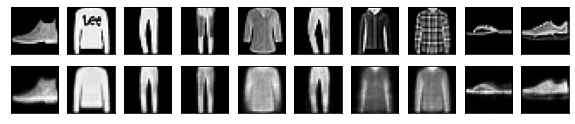

total train loss:16.18086051940918
total test loss:2.553192138671875
[Epoch 2]


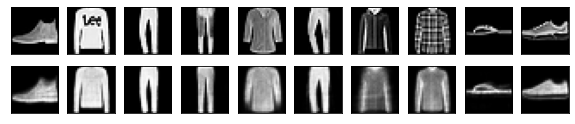

total train loss:14.514667510986328
total test loss:2.4083547592163086
[Epoch 3]


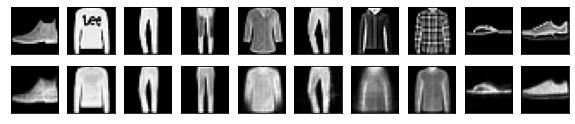

total train loss:13.86502456665039
total test loss:2.2818453311920166
[Epoch 4]


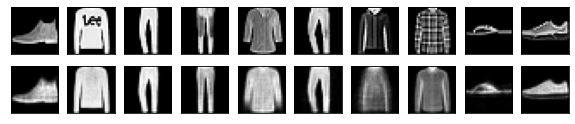

total train loss:13.34880542755127
total test loss:2.273385763168335
[Epoch 5]


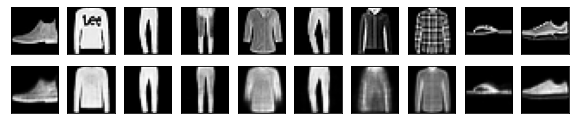

total train loss:13.031573295593262
total test loss:2.2320711612701416
[Epoch 6]


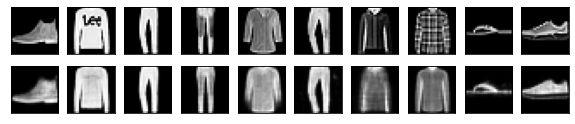

total train loss:12.82167911529541
total test loss:2.136622905731201
[Epoch 7]


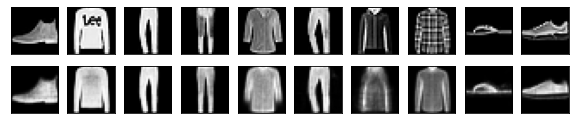

total train loss:12.667638778686523
total test loss:2.1163716316223145
[Epoch 8]


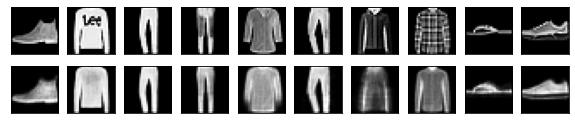

total train loss:12.612364768981934
total test loss:2.111701250076294
[Epoch 9]


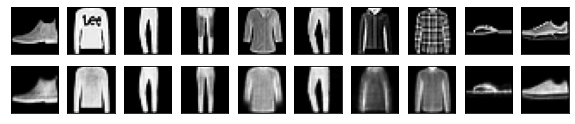

total train loss:12.475346565246582
total test loss:2.1318063735961914
[Epoch 10]


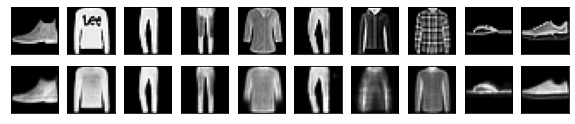

total train loss:12.383273124694824
total test loss:2.098360538482666
[Epoch 11]


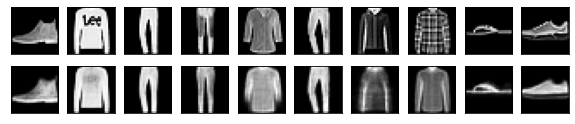

total train loss:12.31859302520752
total test loss:2.0981431007385254
[Epoch 12]


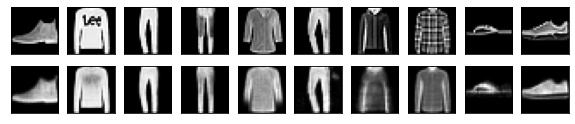

total train loss:12.311593055725098
total test loss:2.132553815841675
[Epoch 13]


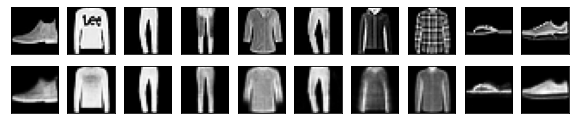

total train loss:12.26206111907959
total test loss:2.127514600753784
[Epoch 14]


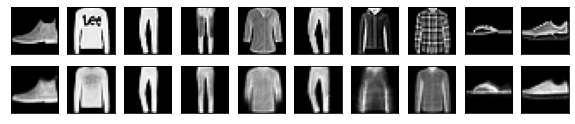

total train loss:12.195356369018555
total test loss:2.06608247756958
[Epoch 15]


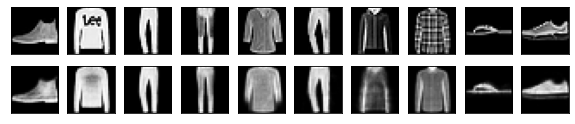

total train loss:12.166933059692383
total test loss:2.1265196800231934
[Epoch 16]


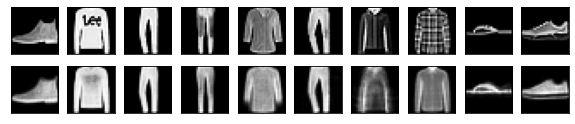

total train loss:12.16767692565918
total test loss:2.1164445877075195
[Epoch 17]


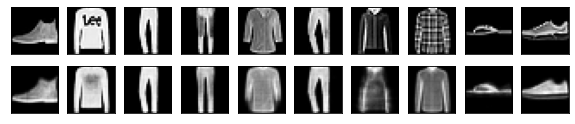

total train loss:12.088011741638184
total test loss:2.062377691268921
[Epoch 18]


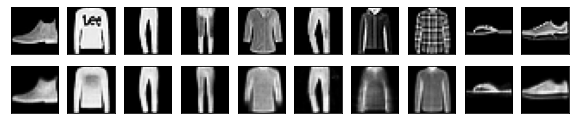

total train loss:12.085806846618652
total test loss:2.0797173976898193
[Epoch 19]


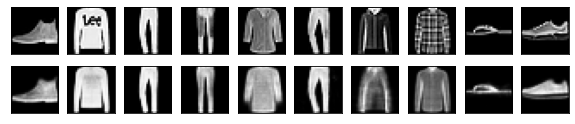

total train loss:12.084503173828125
total test loss:2.0742766857147217
[Epoch 20]


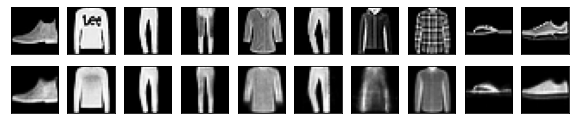

total train loss:12.012662887573242
total test loss:2.036008834838867
[Epoch 21]


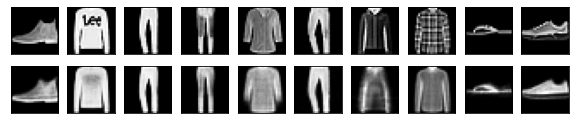

total train loss:12.025808334350586
total test loss:2.078249454498291
[Epoch 22]


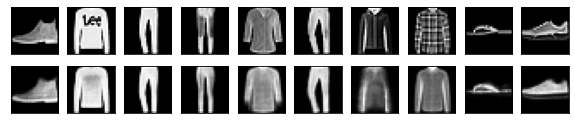

total train loss:12.044374465942383
total test loss:2.044750213623047
[Epoch 23]


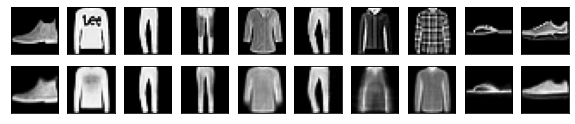

total train loss:11.984502792358398
total test loss:2.039874792098999
[Epoch 24]


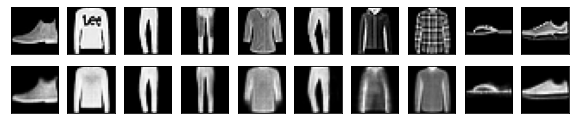

total train loss:11.926767349243164
total test loss:2.0687551498413086
[Epoch 25]


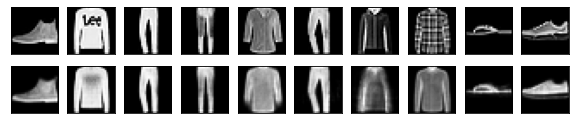

total train loss:11.946772575378418
total test loss:2.0947587490081787
[Epoch 26]


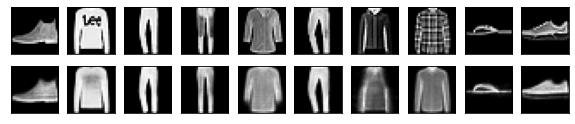

total train loss:11.951526641845703
total test loss:2.0444834232330322
[Epoch 27]


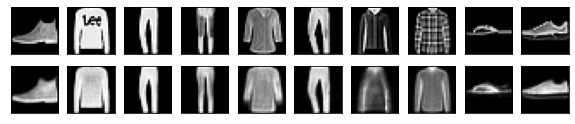

total train loss:11.888988494873047
total test loss:2.066171169281006
[Epoch 28]


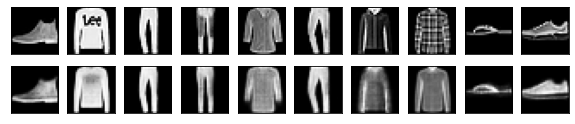

total train loss:11.925350189208984
total test loss:2.038454055786133
[Epoch 29]


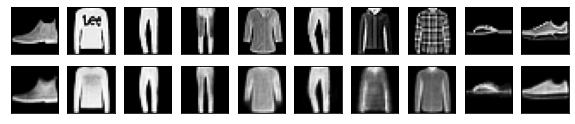

total train loss:11.841730117797852
total test loss:2.088205575942993
[Epoch 30]


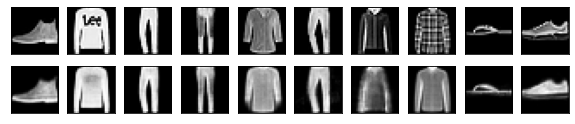

In [12]:
train_losses=[]
test_losses=[]
#학습하기
for epoch in range(1, EPOCH+1):
    loss_epoch = train(autoencoder, train_loader)
    train_losses.append(loss_epoch)

    loss_epoch = test(autoencoder, test_loader)
    test_losses.append(loss_epoch)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

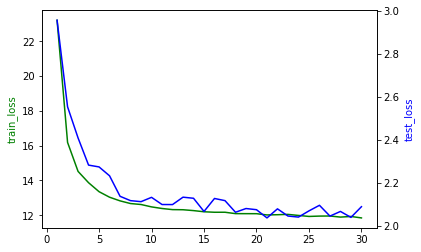

In [13]:
x = range(1,EPOCH+1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, train_losses, 'g-')
ax2.plot(x, test_losses, 'b-')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('test_loss', color='b')
plt.show()
